In [1]:
!pip install binance_historical_data mplfinance stable-baselines3 backtesting tensorboard binance ta line_profiler[ipython] scikit-learn

  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/0c/2a/d3ff6091406bc2207e0adb832ebd15e40ac685811c7e2e3b432bfd969b71/scikit_learn-1.3.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for scipy>=1.5.0 from https://files.pythonhosted.org/packages/6b/d4/d62ce38ba00dc67d7ec4ec5cc19d36958d8ed70e63778715ad626bcbc796/scipy-1.11.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.0 MB/s eta 0:00:00-:--:--
  Obtaining dependency information for joblib>=1.1.1 from https://files.pythonhosted.org/packages/10/40/d551139c85db202f1f384ba8bcf96aca2f329440a844f924c8a0040b6d02/joblib-1.3.2-py3-none-any.whl.metadata
  Obtaining dependency information for threadpoolctl>=2.0.0 from https://files.pythonhosted.org/packages/81/12/fd4dea011af9d69e1cad05c75f3f7202cdcbeac9b712eea58ca779a72865/threadpoolctl-3.2.0-py3-none-any.whl.meta

In [2]:
#!git clone https://github.com/Klok-e/python-price-predict-experiment.git

import sys

sys.path.insert(0, 'python-price-predict-experiment')

In [3]:
import numpy as np
import pandas as pd
from util import download_and_process_data_if_available

df_tickers = download_and_process_data_if_available("cache/df_tickers.pkl")

['ETHBTC', 'LTCBTC', 'BNBBTC', 'NEOBTC', 'QTUMETH', 'EOSETH', 'SNTETH', 'BNTETH', 'BCCBTC', 'GASBTC', 'BNBETH', 'BTCUSDT', 'ETHUSDT', 'HSRBTC', 'OAXETH', 'DNTETH', 'MCOETH', 'ICNETH', 'MCOBTC', 'WTCBTC', 'WTCETH', 'LRCBTC', 'LRCETH', 'QTUMBTC', 'YOYOBTC', 'OMGBTC', 'OMGETH', 'ZRXBTC', 'ZRXETH', 'STRATBTC', 'STRATETH', 'SNGLSBTC', 'SNGLSETH', 'BQXBTC', 'BQXETH', 'KNCBTC', 'KNCETH', 'FUNBTC', 'FUNETH', 'SNMBTC', 'SNMETH', 'NEOETH', 'IOTABTC', 'IOTAETH', 'LINKBTC', 'LINKETH', 'XVGBTC', 'XVGETH', 'SALTBTC', 'SALTETH', 'MDABTC', 'MDAETH', 'MTLBTC', 'MTLETH', 'SUBBTC', 'SUBETH', 'EOSBTC', 'SNTBTC', 'ETCETH', 'ETCBTC', 'MTHBTC', 'MTHETH', 'ENGBTC', 'ENGETH', 'DNTBTC', 'ZECBTC', 'ZECETH', 'BNTBTC', 'ASTBTC', 'ASTETH', 'DASHBTC', 'DASHETH', 'OAXBTC', 'ICNBTC', 'BTGBTC', 'BTGETH', 'EVXBTC', 'EVXETH', 'REQBTC', 'REQETH', 'VIBBTC', 'VIBETH', 'HSRETH', 'TRXBTC', 'TRXETH', 'POWRBTC', 'POWRETH', 'ARKBTC', 'ARKETH', 'YOYOETH', 'XRPBTC', 'XRPETH', 'MODBTC', 'MODETH', 'ENJBTC', 'ENJETH', 'STORJBTC', 'ST

Tickers:   0%|          | 0/1 [00:00<?, ?it/s]

monthly files to download: 0files [00:00, ?files/s]

daily files to download: 0files [00:00, ?files/s]

Tried to dump data for 1 tickers:
---> For NEARUSDT new data saved for: 0 months 0 days


In [4]:
# from google.colab import drive
# drive.mount('/content/drive')
# 
# import time
# import os
# try:
#   os.makedirs("./drive/MyDrive/colab/model-weights/")
# except:
#   pass
# my_model.save(f"./drive/MyDrive/colab/model-weights/model-weights-{time.time()}.pt")

In [5]:
#%load_ext tensorboard
#%tensorboard --logdir tensorboard

In [6]:
from model import LSTMExtractor
from env import CustomEnv
from stable_baselines3.common.vec_env import SubprocVecEnv
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
import torch

from stable_baselines3.common.env_checker import check_env

env = CustomEnv(df_tickers)
check_env(env)
del env

env = make_vec_env(lambda: CustomEnv(df_tickers), n_envs=10, seed=42, vec_env_cls=SubprocVecEnv)

policy_kvargs = dict(activation_fn=torch.nn.LeakyReLU,
                     features_extractor_class=LSTMExtractor,
                     features_extractor_kwargs=dict(lstm_hidden_size=128, lstm_layers=2),
                     net_arch=[256, 256, 256])

# {'gamma': 0.8, 'ent_coef': 0.02, 'gae_lambda': 0.92}
rl_model = PPO("MultiInputPolicy", env,
               verbose=1,
               tensorboard_log="./tensorboard/",
               ent_coef=0.02,
               gae_lambda=0.92,
               gamma=0.8,
               policy_kwargs=policy_kvargs)
# rl_model.set_parameters("rl-model-best-model/best_model/best_model.zip")
rl_model.policy

obs length = {'prices_sequence': (64, 12), 'other': (2,)}
ticker 0; index 303786
ticker 0; index 295100
ticker 0; index 1408485


/mnt/storage/dima/Doc/Documents/Особисте/Проєкти/Projects/price_prediction_experiment/venv/lib/python3.11/site-packages/stable_baselines3/common/env_checker.py:244: UserWarning: Your observation prices_sequence has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


Using cuda device


MultiInputActorCriticPolicy(
  (features_extractor): LSTMExtractor(
    (extractors): ModuleDict(
      (other): Flatten(start_dim=1, end_dim=-1)
      (prices_sequence): LSTM(12, 128, num_layers=2, batch_first=True)
    )
  )
  (pi_features_extractor): LSTMExtractor(
    (extractors): ModuleDict(
      (other): Flatten(start_dim=1, end_dim=-1)
      (prices_sequence): LSTM(12, 128, num_layers=2, batch_first=True)
    )
  )
  (vf_features_extractor): LSTMExtractor(
    (extractors): ModuleDict(
      (other): Flatten(start_dim=1, end_dim=-1)
      (prices_sequence): LSTM(12, 128, num_layers=2, batch_first=True)
    )
  )
  (mlp_extractor): MlpExtractor(
    (policy_net): Sequential(
      (0): Linear(in_features=130, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=256, out_features=256, bias=True)
      (5): LeakyReLU(negative_sl

In [7]:
from stable_baselines3.common.callbacks import CheckpointCallback, EvalCallback

checkpoint_callback = CheckpointCallback(
    save_freq=50_000,
    save_path="rl-model-checkpoints/",
    name_prefix="rl_model",
    verbose=1,
    save_vecnormalize=True,
    save_replay_buffer=True
)
eval_env = make_vec_env(lambda: CustomEnv(df_tickers, episode_length=2048), seed=42)
eval_callback = EvalCallback(eval_env, best_model_save_path="rl-model-best-model/best_model",
                             log_path="rl-model-best-model/results", eval_freq=50_000, verbose=1,
                             n_eval_episodes=5)

rl_model.learn(total_timesteps=100000, callback=[checkpoint_callback, eval_callback])

obs length = {'prices_sequence': (64, 12), 'other': (2,)}
Logging to ./tensorboard/PPO_12


/mnt/storage/dima/Doc/Documents/Особисте/Проєкти/Projects/price_prediction_experiment/venv/lib/python3.11/site-packages/stable_baselines3/common/callbacks.py:403: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f0bab3d4b10> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f0b6cf39e10>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.02e+03 |
|    ep_rew_mean     | -1.83    |
| time/              |          |
|    fps             | 4517     |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 20480    |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.02e+03    |
|    ep_rew_mean          | -1.83       |
| time/                   |             |
|    fps                  | 737         |
|    iterations           | 2           |
|    time_elapsed         | 55          |
|    total_timesteps      | 40960       |
| train/                  |             |
|    approx_kl            | 0.032096304 |
|    clip_fraction        | 0.337       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.07       |
|    explained_variance   | -5.2        |
|    learning_rate        | 0.

In [8]:
evaluations = np.load("rl-model-best-model/results/evaluations.npz")
evaluations_df = pd.DataFrame()
evaluations_df["timesteps"] = evaluations["timesteps"]
evaluations_df["results"] = evaluations["results"].mean(axis=1)
evaluations_df

,timesteps,results
0,500000,-2.026398
1,1000000,-3.814865


In [10]:
from backtest import create_backtest_model_with_data
from backtesting import set_bokeh_output

for df,_,scaler in df_tickers: 
    bt = create_backtest_model_with_data(rl_model, df, scaler)
    stats = bt.run()
    print(bt._results._equity_curve.head())


/mnt/storage/dima/Doc/Documents/Особисте/Проєкти/Projects/price_prediction_experiment/venv/lib/python3.11/site-packages/backtesting/backtesting.py:1054: FutureWarning: Index.is_numeric is deprecated. Use pandas.api.types.is_any_real_numeric_dtype instead
  (data.index.is_numeric() and
/mnt/storage/dima/Doc/Documents/Особисте/Проєкти/Projects/price_prediction_experiment/backtest.py:43: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  return Backtest(backtest_dataset, NeuralNetStrat, commission=.001, exclusive_orders=True)


buy
gain 0.010070515915487526
buy
gain 0.0023677778086176327
buy
gain 0.00010669006915086789
buy
gain 0.006540392624542158
buy
gain 0.015659954210599004
buy
gain 0.010798662396795217
buy
gain -0.01719803590232234
buy
gain 0.007388572726645517
buy
gain 0.0059651943249780645
buy
gain 0.0045551611650481725
buy
gain 0.010399812429913098
buy
gain 0.010342002298733713
buy
gain 0.02073645086665998
buy
gain 0.016419543253154836
buy
gain 0.01868254230071383
buy
gain 0.010288830975354933
buy
gain 1.5862661769821943e-05
buy
gain 0.006717445509212011
buy
gain 0.008745417407492472
buy
gain 0.012366204321583482
buy
gain 0.008136234047704815
buy
gain 0.01050031525194801
buy
gain 0.010645406948341568
buy
gain 0.0042882789388179274
buy
gain -4.3677861831653794e-05
buy
gain 0.006084006116994139
buy
         Equity  DrawdownPct  DrawdownDuration
613071  10000.0          0.0               NaN
613072  10000.0          0.0               NaN
613073  10000.0          0.0               NaN
613074  10000.0     

In [ ]:
bt._results._equity_curve.head()

In [ ]:
set_bokeh_output(notebook=False)
bt.plot()

In [1]:
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
from stable_baselines3 import PPO

from backtest import create_backtest_model_with_data
from util import download_and_process_data_if_available

rl_model = PPO.load("cherry-picked-best-models/rl-model-best1.pt")

df_tickers = download_and_process_data_if_available("cache/df_tickers.pkl")

lst=[]
for _, df, scaler in df_tickers[:2]:
    bt = create_backtest_model_with_data(rl_model, df, scaler, "2023-5-1", "2023-5-4")
    stats = bt.run()
    lst.append(bt._results._equity_curve["Equity"])

/mnt/storage/dima/Doc/Documents/Особисте/Проєкти/Projects/price_prediction_experiment/venv/lib/python3.11/site-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ... 
 
 Warning: Requesting CDN BokehJS version '3.3.0rc2' from local development version '3.3.0rc2+2.g273f1258'. This configuration is unsupported and may not work!

Loading data from cache
equity 999001.0003661462
equity 995914.9510395105
equity 995554.400867152
equity 994650.8552960166
equity 988859.1395934186
equity 991210.9979602832
equity 987066.618088549
equity 983481.4794500986
equity 979913.451872819
equity 978487.5098926803
equity 975999.6740274467
equity 977772.7561218899
equity 975286.7348005077
equity 974379.9333003592
equity 975067.4608069229
equity 971536.671994795
equity 966965.3893179174
equity 966079.3707932291
equity 964148.1777493525
equity 961172.6894601658
equity 963435.6097038925
equity 957336.617322451
equity 958029.7058377042
equity 954550.5132988141
equity 953161.2581252189
equity 949172.8382718026
equity 950394.9296586564
equity 948495.0920115837
equity 943482.0960179956
equity 940032.964975932
equity 933496.2437176876
equity 939370.8762314835
equity 933890.5976948056
equity 932533.3845260576
equity 930159.3930928266
equity 928810.2020761083
equity 924888.0189037782
equity 923038.9863748183
equity 921698.2483239307
equity 

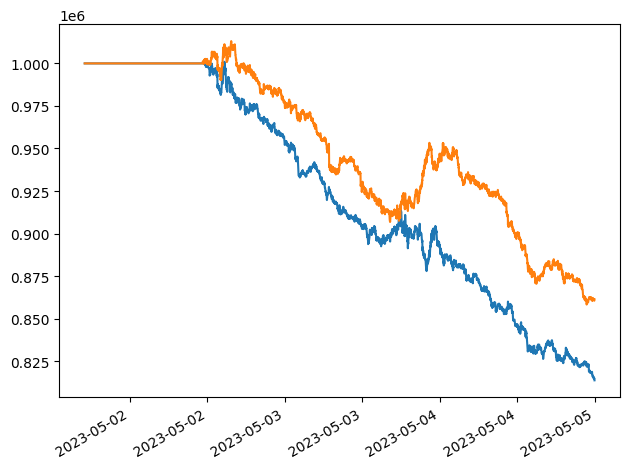

In [9]:
# fig = plt.figure()
# ax = fig.add_subplot(111)
for l in lst:
    plt.plot(l)

# Set date format on the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gcf().autofmt_xdate()

# Improve layout
plt.tight_layout()

plt.show()